<H3 align='center'> Challenge Kaggle - Detección de posiciones de Yoga </H3>
<hr style="height:2px;border:none"/>

**Integrantes:** \\

**Daniel Peralta**  -  201621053-9 \\
**Philip Guerra**   -  201623003-3

El desafío consiste en predecir las posiciones de yoga a partir de una imagen. Cada imagen contará con dos clasificaciones, la superclase y la subclase. La primera podrá tomar 7 valores:


0 : Standing \\
1 : Sitting \\
2 : Balanced \\
3 : Inverted \\
4 : Reclining \\
5 : Wheel \\

La subclase puede tomar 20 valores distintos:

6 : straight \\
7 : forward bend    
8 : side bend \\
9 : other1 \\
10 : normal1 \\
11 : normal2 \\
12 : split \\
13 : forward bend \\
14 : twist \\
15 : front \\
16 : side \\
17 : legs1 \\
18 : legs2 \\
19 : up-facing1 \\
20 : down-facing1 \\
21 : side facing \\
22 : plank balance \\
23 : up-facing2 \\
24 : down-facing2 \\
25 : other2.




In [1]:
#montamos google drive
from google.colab import drive

colab_flag = True

if (colab_flag):
    drive.mount('/content/drive')


path = '/content/drive/MyDrive/2021-1/Redes_neuronales_artificiales/Tarea2'

Mounted at /content/drive


Se parte cargando las librerias necesarias y analizando la cantidad de datos.

In [2]:
#
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


#Para trabajar sobre imagenes
import cv2
import random
import os
import matplotlib.image as mpimg
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report

#tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout,Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

In [3]:
#para data entrenamiento
path2 = path + '/Yoga-Dataset-actualizado/'
data_train = pd.read_csv(path2 + 'yoga_train2.csv' ,header=0,engine='python')
print(data_train.shape)
data_train.head()

(1250, 2)


,name,clase_sub
0,0.jpg,1 14
1,1.jpg,1 14
2,2.jpg,1 14
3,4.jpg,1 14
4,6.jpg,1 14


El conjunto de entrenamiento son un total de 1250. Se procede a separar la superclase y subclase en dos columnas distintas.

In [4]:
#separamos la superclase con la subclase del data train
aux = data_train[data_train.columns[1]].str.split(' ', n=1,expand = True)
data_train['super'] =aux[0]
data_train['subclase']=aux[1]
print(data_train.shape)
data_train.head()

(1250, 4)


,name,clase_sub,super,subclase
0,0.jpg,1 14,1,14
1,1.jpg,1 14,1,14
2,2.jpg,1 14,1,14
3,4.jpg,1 14,1,14
4,6.jpg,1 14,1,14


Se carga el conjunto de test donde se probará la eficiencia de la red neuronal. Contiene un total de 378 ejemplos.

In [5]:
#para data test
path2 = path + '/Yoga-Dataset-actualizado/'
data_test = pd.read_csv(path2 + 'yoga_test2.csv' ,header=0,engine='python')
del data_test["Unnamed: 1"]
print(data_test.shape)
data_test.head()

(378, 1)


,name
0,1400.jpg
1,1402.jpg
2,1403.jpg
3,1404.jpg
4,1405.jpg


### Análisis de datos

En primera instacia, analizamos la cantidad de datos para cada subclase y clase.

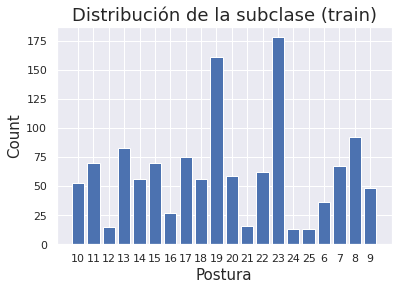

In [6]:
unique, counts = np.unique(data_train.subclase, return_counts=True)
y_pos = np.arange(len(unique))
# Create bars
plt.bar(y_pos, counts)

plt.xticks(y_pos, unique)

plt.xlabel("Postura", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Distribución de la subclase (train)", fontsize=18)
plt.show()

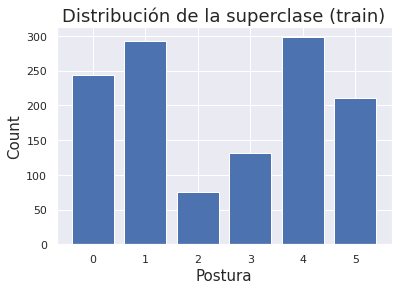

In [7]:
unique, counts = np.unique(data_train.super, return_counts=True)
y_pos = np.arange(len(unique))
# Create bars
plt.bar(y_pos, counts)

plt.xticks(y_pos, unique)

plt.xlabel("Postura", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Distribución de la superclase (train)", fontsize=18)
plt.show()

Se analiza la combinación de la superclase y subclase.

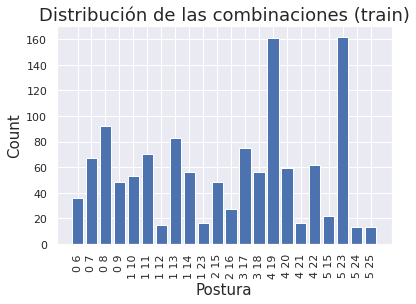

In [8]:
unique, counts = np.unique(data_train.clase_sub, return_counts=True)
y_pos = np.arange(len(unique))
# Create bars
plt.bar(y_pos, counts)
#plt.bar(figsize=(cm_to_inch(25), cm_to_inch(15)))
plt.xticks(y_pos, unique)
# plt.xticks(figsize=(10,6))
plt.xticks(rotation=90)
plt.xlabel("Postura", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Distribución de las combinaciones (train)", fontsize=18)
plt.show()

Se descargan las imágenes para el train y test.

In [9]:
!wget  http://www.inf.utfsm.cl/~cvalle/Yoga-Dataset.rar
!unrar x "/content/Yoga-Dataset.rar" "/content/"

--2021-07-11 00:53:11--  http://www.inf.utfsm.cl/~cvalle/Yoga-Dataset.rar
Resolving www.inf.utfsm.cl (www.inf.utfsm.cl)... 200.1.19.11, 2800:270:c::11
Connecting to www.inf.utfsm.cl (www.inf.utfsm.cl)|200.1.19.11|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.inf.utfsm.cl/~cvalle/Yoga-Dataset.rar [following]
--2021-07-11 00:53:12--  https://www.inf.utfsm.cl/~cvalle/Yoga-Dataset.rar
Connecting to www.inf.utfsm.cl (www.inf.utfsm.cl)|200.1.19.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244765013 (233M) [application/x-rar-compressed]
Saving to: ‘Yoga-Dataset.rar’

Yoga-Dataset.rar    100%[===================>] 233.43M  23.1MB/s    in 11s     

2021-07-11 00:53:23 (21.7 MB/s) - ‘Yoga-Dataset.rar’ saved [244765013/244765013]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Yoga-Dataset.rar

Creating    /content/Yoga-Dataset                                     OK
Creating 

Existe un claro desbalance en la data, lo que trae el problema de que la red neuronal solo aprende las clases más frecuentes. Para combatir este problema lo que se hace es aplicar oversample, es decir, empezar a repetir datos para las clases menos frecuentes hasta lograr balancear la data. \\ 

Se crerá una red que prediga la combinación de la superclase y la subclase. Se tomó esta decisión debido a la complejidad que puede implicar un problema de clasificación multilabel respecto a las neuronas de salida y la cantidad de clases. 

Se realizará oversample hasta tener una cantidad mínima de 50 datos para cada clase. Se creará un diccionario donde la llave sea la clase y el contenido sea la lista de imágenes. 


In [10]:
Aux = {}
#problemas = ['698.jpg','1515.jpg','1845.jpg','1270.jpg','1275.jpg','227.jpg','332.jpg','292.jpg','545.jpg']
problemas = []
tf.random.set_seed(1234)
ridxs = tf.random.shuffle(tf.range(50))
for k in unique:
  L1 = data_train[data_train.clase_sub == k].name.to_list()
  #a = False
  for name in L1:
      if name in problemas:
        L1.remove(name)
        #print('hola')
  if True: #no hace nada :)
      try:
        Aux[k] = tf.gather(L1, ridxs).numpy() #15
      except:
        try:
          Aux[k] = tf.gather(L1+L1, ridxs).numpy() #30
        except:
          try:
            Aux[k] = tf.gather(L1+L1+L1, ridxs).numpy() #45
          except:
            try:
              Aux[k] = tf.gather(L1+L1+L1+L1, ridxs).numpy()  #60
            except:
              try:
                Aux[k] = tf.gather(L1+L1+L1+L1+L1, ridxs).numpy() 
              except:
                try:
                  Aux[k] = tf.gather(L1+L1+L1+L1+L1+L1, ridxs).numpy()
                except:
                  try:
                    Aux[k] = tf.gather(L1+L1+L1+L1+L1+L1+L1, ridxs).numpy()
                  except:
                    Aux[k] = tf.gather(L1+L1+L1+L1+L1+L1+L1+L1, ridxs).numpy() # 

pd.DataFrame.from_dict(Aux)

,0 6,0 7,0 8,0 9,1 10,1 11,1 12,1 13,1 14,1 23,2 15,2 16,3 17,3 18,4 19,4 20,4 21,4 22,5 15,5 23,5 24,5 25
0,b'235.jpg',b'572.jpg',b'419.jpg',b'1157.jpg',b'902.jpg',b'444.jpg',b'903.jpg',b'863.jpg',b'746.jpg',b'525.jpg',b'870.jpg',b'742.jpg',b'592.jpg',b'819.jpg',b'767.jpg',b'375.jpg',b'893.jpg',b'691.jpg',b'47.jpg',b'682.jpg',b'127.jpg',b'88.jpg'
1,b'242.jpg',b'227.jpg',b'291.jpg',b'921.jpg',b'379.jpg',b'42.jpg',b'904.jpg',b'834.jpg',b'18.jpg',b'511.jpg',b'313.jpg',b'740.jpg',b'481.jpg',b'724.jpg',b'334.jpg',b'159.jpg',b'873.jpg',b'348.jpg',b'63.jpg',b'111.jpg',b'124.jpg',b'85.jpg'
2,b'239.jpg',b'224.jpg',b'287.jpg',b'917.jpg',b'376.jpg',b'39.jpg',b'1176.jpg',b'831.jpg',b'15.jpg',b'525.jpg',b'193.jpg',b'737.jpg',b'478.jpg',b'721.jpg',b'331.jpg',b'156.jpg',b'893.jpg',b'345.jpg',b'59.jpg',b'108.jpg',b'121.jpg',b'82.jpg'
3,b'245.jpg',b'230.jpg',b'295.jpg',b'937.jpg',b'382.jpg',b'45.jpg',b'907.jpg',b'837.jpg',b'21.jpg',b'514.jpg',b'316.jpg',b'743.jpg',b'484.jpg',b'727.jpg',b'337.jpg',b'262.jpg',b'876.jpg',b'351.jpg',b'66.jpg',b'114.jpg',b'127.jpg',b'88.jpg'
4,b'1068.jpg',b'556.jpg',b'399.jpg',b'949.jpg',b'637.jpg',b'428.jpg',b'1177.jpg',b'847.jpg',b'536.jpg',b'525.jpg',b'783.jpg',b'252.jpg',b'576.jpg',b'803.jpg',b'500.jpg',b'273.jpg',b'893.jpg',b'651.jpg',b'53.jpg',b'665.jpg',b'124.jpg',b'85.jpg'
5,b'142.jpg',b'218.jpg',b'282.jpg',b'618.jpg',b'77.jpg',b'32.jpg',b'1170.jpg',b'778.jpg',b'10.jpg',b'520.jpg',b'187.jpg',b'732.jpg',b'308.jpg',b'716.jpg',b'177.jpg',b'151.jpg',b'888.jpg',b'206.jpg',b'54.jpg',b'103.jpg',b'129.jpg',b'90.jpg'
6,b'244.jpg',b'229.jpg',b'293.jpg',b'923.jpg',b'381.jpg',b'44.jpg',b'906.jpg',b'836.jpg',b'20.jpg',b'513.jpg',b'315.jpg',b'742.jpg',b'483.jpg',b'726.jpg',b'336.jpg',b'261.jpg',b'875.jpg',b'350.jpg',b'65.jpg',b'113.jpg',b'126.jpg',b'87.jpg'
7,b'243.jpg',b'228.jpg',b'292.jpg',b'922.jpg',b'380.jpg',b'43.jpg',b'905.jpg',b'835.jpg',b'19.jpg',b'512.jpg',b'314.jpg',b'741.jpg',b'482.jpg',b'725.jpg',b'335.jpg',b'160.jpg',b'874.jpg',b'349.jpg',b'64.jpg',b'112.jpg',b'125.jpg',b'86.jpg'
8,b'246.jpg',b'231.jpg',b'296.jpg',b'938.jpg',b'383.jpg',b'178.jpg',b'908.jpg',b'838.jpg',b'22.jpg',b'515.jpg',b'317.jpg',b'881.jpg',b'485.jpg',b'728.jpg',b'338.jpg',b'263.jpg',b'877.jpg',b'352.jpg',b'67.jpg',b'115.jpg',b'128.jpg',b'89.jpg'
9,b'241.jpg',b'226.jpg',b'290.jpg',b'919.jpg',b'378.jpg',b'41.jpg',b'903.jpg',b'833.jpg',b'17.jpg',b'527.jpg',b'195.jpg',b'739.jpg',b'480.jpg',b'723.jpg',b'333.jpg',b'158.jpg',b'895.jpg',b'347.jpg',b'62.jpg',b'110.jpg',b'123.jpg',b'84.jpg'


Revisamos imágenes de forma aleatoria, incluyendo la misma imagen con 5 técnicas distintas de dataugmentation. Estas son realizando un flip horizontal, rotando la imagen en 20 grados, escalando la imagen, trasladándola y viéndola de forma binaria.

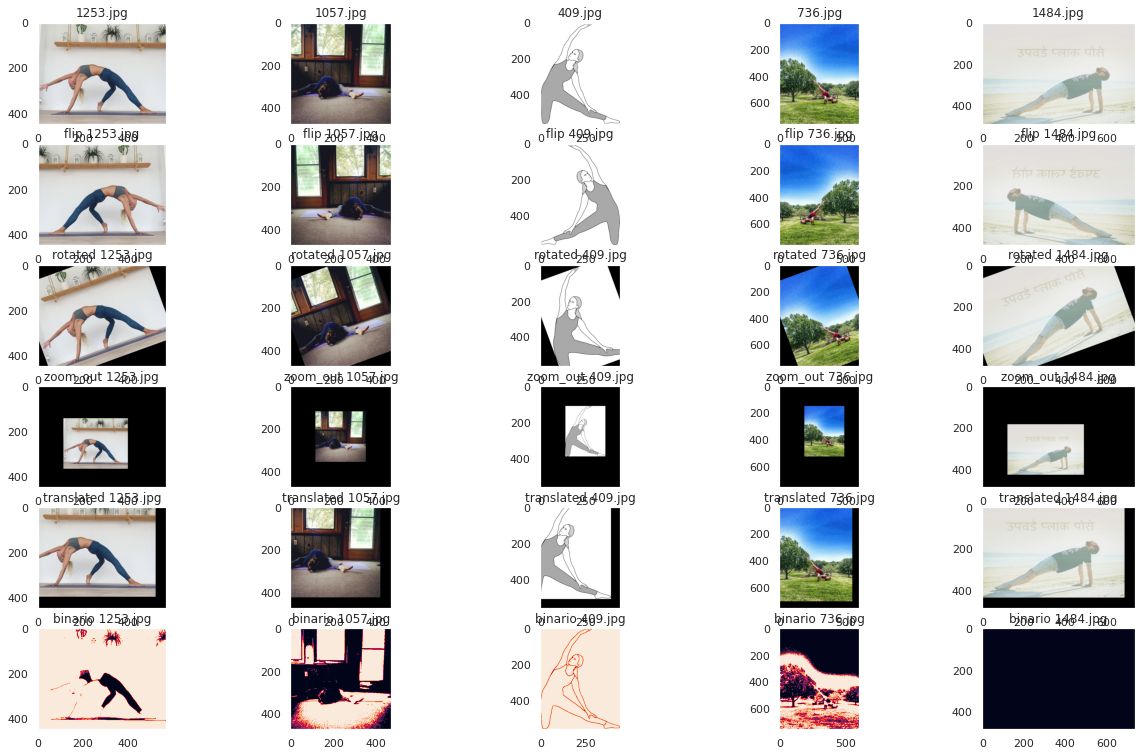

In [11]:
from skimage import transform as trf
#img_folder = path2+'Images'
#img_folder = '/content/Yoga-Dataset/Images/'
img_folder = '/content/Yoga-Dataset/Images'
shape=(128,128)
#fig = plt.figure(figsize=(16, 16))
fig = plt.figure(figsize=(25,13))
gs = gridspec.GridSpec(6, 6)

for i in range(5):
    file = random.choice(os.listdir(img_folder)) # elección aleatoria
    image_path= os.path.join(img_folder, file)
    ax = plt.subplot(gs[0,i])
    #img= mpimg.imread(image_path)
    #img = Image.open(image_path).resize(shape)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.grid(False)
    ax.set_title(file)

    ax = plt.subplot(gs[1,i])
    #img_mirror = ImageOps.mirror(img)
    img_mirror = cv2.flip(img,1)
    ax.imshow(img_mirror)
    #ax = fig.add_subplot(1, 5,i+1)
    ax.grid(False)
    ax.set_title('flip '+file)

    image=img
    # specify x and y coordinates to be used for shifting (mid points)
    shift_x, shift_y = image.shape[0]/2, image.shape[1]/2

    # translation by certain units
    matrix_to_topleft = trf.SimilarityTransform(translation=[-shift_x, -shift_y])
    matrix_to_center = trf.SimilarityTransform(translation=[shift_x, shift_y])

    # rotation
    rot_transforms =  trf.AffineTransform(rotation=np.deg2rad(20))
    rot_matrix = matrix_to_topleft + rot_transforms + matrix_to_center
    rot_image = trf.warp(image, rot_matrix)    
    ax = plt.subplot(gs[2,i])
    ax.imshow(rot_image)
    ax.grid(False)
    ax.set_title('rotated '+file)

    # scaling 
    scale_transforms = trf.AffineTransform(scale=(2, 2))
    scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
    scale_image_zoom_out = trf.warp(image, scale_matrix)
    ax = plt.subplot(gs[3,i])
    ax.imshow(scale_image_zoom_out)
    ax.grid(False)
    ax.set_title('zoom_out '+file)

    #translation
    transaltion_transforms = trf.AffineTransform(translation=(50, 50))
    translated_image = trf.warp(image, transaltion_transforms)
    ax = plt.subplot(gs[4,i])
    ax.imshow(translated_image)
    ax.grid(False)
    ax.set_title('translated '+file)

    #binario
    bin_image = image[:, :, 0] > 100
    ax = plt.subplot(gs[5,i])
    ax.imshow(bin_image)
    ax.grid(False)
    ax.set_title('binario '+file)

    # ax.title.set_text(file)
    # plt.imshow(img)
plt.show()

Considerando las imágenes antes vistas, se añadirá al conjunto de pruebas las imágenes con flip horizontal, con zoom y trasladadas. No se tomará en cuenta el procesamiento binario ya que es propenso a confundir el fondo con la piel de las personas, y tampoco las rotadas ya que se puede confundir con distintas poses de yoga.

In [12]:
#problemas = ['698.jpg','1515.jpg','1845.jpg','1270.jpg','1275.jpg','227.jpg','332.jpg','292.jpg','545.jpg']
problemas = []
X, y = [], []
pruebas = [64,224,256,128][1]
shape = (pruebas,pruebas)
#img_folder = path2+'Images'
img_folder = '/content/Yoga-Dataset/Images'
width=pruebas
height = pruebas
for key in Aux:
    for i in Aux[key]:
        k = i.decode("utf-8") #para que no esté en byte string
        if k not in problemas: 
            image = np.asarray(Image.open(img_folder+'/'+k).resize(shape).convert('RGB')).astype('float32')
            # hacemos un resize del tamaño de las imágenes antes de ingresarlo a nuestro modelo
            image = cv2.resize(image, (width, height)) # 
            image_mirror = cv2.flip(image, 1)  #flip horizontal
            image = np.array(image)
            image = image.astype('float32')
            image = image/255 # escalar a [0, 1]
            
            X.append(image)

            y.append(key)

            #flip horizontal
            image_mirror = np.array(image_mirror)
            image_mirror = image_mirror.astype('float32')
            image_mirror = image_mirror/255  # escalar a [0, 1]
            
            X.append(image_mirror)
            y.append(key)

            #para rotar
            # specify x and y coordinates to be used for shifting (mid points)
            shift_x, shift_y = image.shape[0]/2, image.shape[1]/2

            # translation by certain units
            matrix_to_topleft = trf.SimilarityTransform(translation=[-shift_x, -shift_y])
            matrix_to_center = trf.SimilarityTransform(translation=[shift_x, shift_y])
            # #rotated
            # rot_transforms =  trf.AffineTransform(rotation=np.deg2rad(20))
            # rot_matrix = matrix_to_topleft + rot_transforms + matrix_to_center
            # rot_image = trf.warp(image, rot_matrix) 
            # X.append(rot_image)
            # y.append(key)
            #scaling
            scale_transforms = trf.AffineTransform(scale=(2, 2))
            scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
            scale_image_zoom_out = trf.warp(image, scale_matrix)
            X.append(scale_image_zoom_out)
            y.append(key)
            #translation
            transaltion_transforms = trf.AffineTransform(translation=(50, 50))
            translated_image = trf.warp(image, transaltion_transforms)
            X.append(translated_image)
            y.append(key)


X = np.array(X)
#X_mean = X.mean()
#X = (X-X.mean())/X.std()
y = np.array(y)
X.shape, y.shape

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


((4400, 224, 224, 3), (4400,))

Se muestra la nueva distribución de las clases. Se observan que están equilibradas y con una mayor cantidad de ejemplos.

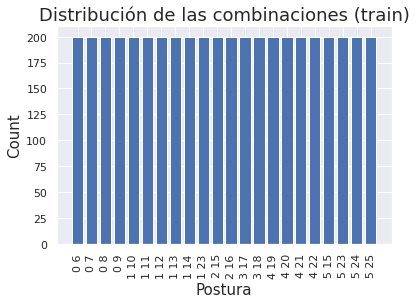

In [13]:
unique, counts = np.unique(y, return_counts=True)
y_pos = np.arange(len(unique))
# Create bars
plt.bar(y_pos, counts)
#plt.bar(figsize=(cm_to_inch(25), cm_to_inch(15)))
plt.xticks(y_pos, unique)
# plt.xticks(figsize=(10,6))
plt.xticks(rotation=90)
plt.xlabel("Postura", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Distribución de las combinaciones (train)", fontsize=18)
plt.show()

Lo mismo pero para el test:

In [14]:
#problemas = ['698.jpg','1515.jpg','1845.jpg','1270.jpg','1275.jpg','227.jpg','332.jpg','292.jpg','545.jpg']
X_test = []
pruebas = [64,224,256,128][1]
shape = (pruebas,pruebas)
width=pruebas
height = pruebas
#img_folder = path2+'Images'
img_folder = '/content/Yoga-Dataset/Images'
for n, k in enumerate(data_test.name):
    if k not in problemas: 
        image = np.asarray(Image.open(img_folder+'/'+k).resize(shape).convert('RGB')).astype('float32')
        image = cv2.resize(image, (width, height)) # por ejemplo, 52 x 52 x 3 (3 canales => rojo, verde y azul)
        image = np.array(image)
        image = image.astype('float32')
        image = image/255
        X_test.append(image)
        
X_test = np.array(X_test)
#X_test = (X_test-X_mean)/X_test.std()
X_test.shape

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


(378, 224, 224, 3)

Se cargarán las imágenes para el entrenamiento y test.

In [15]:
#X ya está como array, Y lo pasamos a one hot encoding
Y = pd.get_dummies(y)
X.shape, Y.shape 

((4400, 224, 224, 3), (4400, 22))

Se generan los conjuntos de train, validation y test.

In [17]:
# split en train, val y test
_validation_split = 0.2

# Split de los ejemplos de entrenamiento
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, Y, test_size=0.2,stratify=Y ,random_state=0)
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train1, y_train1, test_size=_validation_split,stratify=y_train1,random_state=0)


print("X,y Shapes:", X.shape, Y.shape)
print("X,y Train Shapes:", X_train1.shape, y_train1.shape)
print("X,y Val Shapes:", X_val1.shape, y_val1.shape)
print("X,y Test Shapes:", X_test1.shape, y_test1.shape)



X,y Shapes: (4400, 224, 224, 3) (4400, 22)
X,y Train Shapes: (2816, 224, 224, 3) (2816, 22)
X,y Val Shapes: (704, 224, 224, 3) (704, 22)
X,y Test Shapes: (880, 224, 224, 3) (880, 22)


## Modelos de prueba
Se probarán dos modelos de redes neuronales, que tendrán como entrada la imagen de la posición de yoga y como salida la clasificación de la combinación entre la superclase y subclase.



1.   La primera red cuenta con 6 capas convolucionales y 2 capas densas. Se aplican capas de dropout para disminuir el overfitting.
2.   La segunda red será una preentrenada. En particular se usará la red llamada VGG16 (Simonyan and Zisserman, 2015). Se añade una capa de dropout para disminuir el overfitting. Las razones por las que se seleccionó esta red en desmedro del resto de redes preentrenadas disponibles en Keras son: 

    *   Contiene relativamente pocas capas convolucionales: 13 capas convolucionales: 13 capas convolucionales y 3 densas.
    *   Logra un excelente resultado en la competencia ImageNet (ILSVRC-2014), entre el 96% y 97%.
    *   Posee una arquitectura fácil de comprender.  

En la siguiente imagen se muestra la arquitectura de la red VGG16:

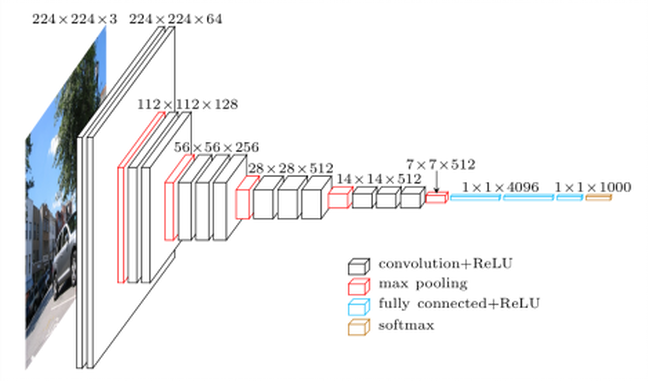

### Modelo 1

Model: "Yoga_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Vamospa (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 51, 51, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0  

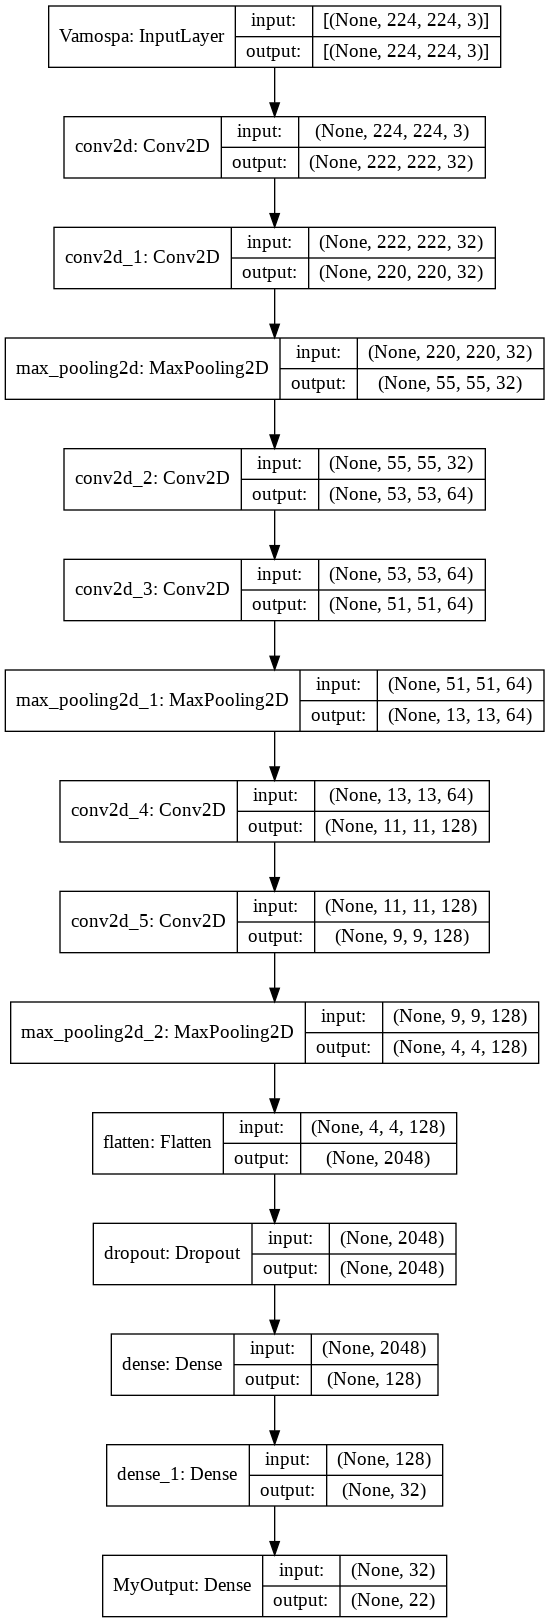

In [18]:
from tensorflow.keras.regularizers import L1, L2, L1L2

def get_model_CNN(activation_func,seed=1234,reg=None): #
  
    tf.random.set_seed(seed)
    input = keras.Input(shape=X_train1.shape[1:], name='Vamospa')

    x1 = layers.Conv2D(filters = 32, kernel_size = 3, strides=(1, 1), activation = activation_func,activity_regularizer=reg)(input)
    x1 = layers.Conv2D(filters = 32, kernel_size = 3, strides=(1, 1), activation = activation_func,activity_regularizer=reg)(x1)  
    x1 = layers.MaxPooling2D(pool_size=(2,2), strides=(4,4), padding='valid')(x1)
    x1 = layers.Conv2D(filters = 64, kernel_size = 3, strides=(1, 1), activation = activation_func,activity_regularizer=reg)(x1)  
    x1 = layers.Conv2D(filters = 64, kernel_size = 3, strides=(1, 1), activation = activation_func,activity_regularizer=reg)(x1)
    x1 = layers.MaxPooling2D(pool_size=(2,2), strides=(4,4), padding='valid')(x1)
    x1 = layers.Conv2D(filters = 128, kernel_size = 3, strides=(1, 1), activation = activation_func,activity_regularizer=reg)(x1)  
    x1 = layers.Conv2D(filters = 128, kernel_size = 3, strides=(1, 1), activation = activation_func,activity_regularizer=reg)(x1)
    x1 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(x1)
    
    x = layers.Flatten()(x1)
    x = layers.Dropout(0.1)(x)
    #x = layers.Dense(256, activation=activation_func)(x)
    x = layers.Dense(128, activation=activation_func)(x)
    x = layers.Dense(32, activation=activation_func)(x)

    output = layers.Dense(y_train1.shape[1], activation='softmax', name='MyOutput')(x) 

    model = keras.Model(inputs=input, outputs=output, name='Yoga_CNN')

    return model

#model2 = get_model_CNN2('relu')
#model2 = get_model_CNN3('relu',reg=L2(0.002))  #ANDA DE LA v
model = get_model_CNN('relu') #0.20 papa :)
#model2 = get_model_CNN4('relu',reg=L2(0.002))  Como el ñato
#model2 = get_model_CNN6('tanh') 
model.summary()

keras.utils.plot_model(model, show_shapes=True)

### Modelo 2

58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

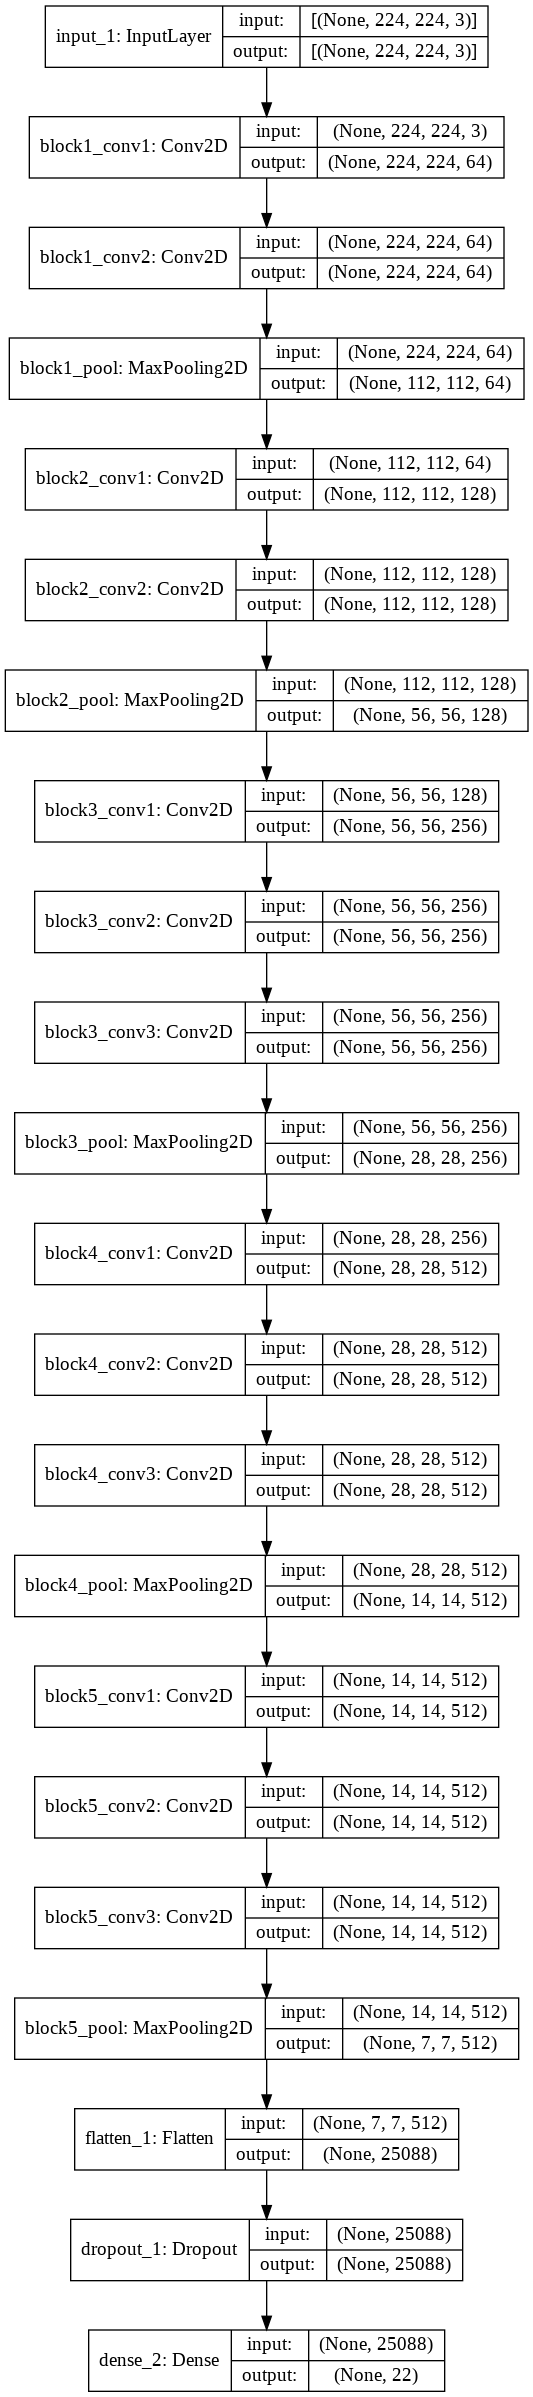

In [33]:

from tensorflow.keras.applications import resnet50, VGG16 , InceptionV3, Xception
# base_model =  Xception(weights=path+'/keras-pretrained-models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(300, 300, 3))
tf.random.set_seed(1234)
vgg16 = VGG16(input_shape = X_train1.shape[1:], weights='imagenet', include_top=False)
for layer in vgg16.layers:
  layer.trainable = False
x = Flatten()(vgg16.output)
x = Dropout(0.1)(x)
#x = layers.Dense(128, activation='relu')(x)
prediction = Dense(y_train1.shape[1], activation='softmax')(x)

# creat model object
model2 = keras.Model(inputs = vgg16.input, outputs = prediction)

model2.summary()

keras.utils.plot_model(model2, show_shapes=True)

In [19]:
from keras.callbacks import History,EarlyStopping
from keras import backend as K
my_callbacks = [History(), EarlyStopping(patience=10, monitor="val_loss",restore_best_weights=True)] 



### Entrenamiento Prueba 1

Epoch 1/30
44/44 [==============================] - 40s 141ms/step - loss: 3.0942 - accuracy: 0.0415 - val_loss: 3.0911 - val_accuracy: 0.0540
Epoch 2/30
44/44 [==============================] - 6s 130ms/step - loss: 3.0914 - accuracy: 0.0444 - val_loss: 3.0910 - val_accuracy: 0.0455
Epoch 3/30
44/44 [==============================] - 6s 137ms/step - loss: 3.0906 - accuracy: 0.0433 - val_loss: 3.0915 - val_accuracy: 0.0455
Epoch 4/30
44/44 [==============================] - 6s 131ms/step - loss: 3.0891 - accuracy: 0.0497 - val_loss: 3.0908 - val_accuracy: 0.0455
Epoch 5/30
44/44 [==============================] - 6s 136ms/step - loss: 3.0871 - accuracy: 0.0447 - val_loss: 3.0887 - val_accuracy: 0.0526
Epoch 6/30
44/44 [==============================] - 6s 137ms/step - loss: 3.0692 - accuracy: 0.0582 - val_loss: 3.0792 - val_accuracy: 0.0582
Epoch 7/30
44/44 [==============================] - 6s 131ms/step - loss: 3.0373 - accuracy: 0.0646 - val_loss: 3.1288 - val_accuracy: 0.0653
Epoch

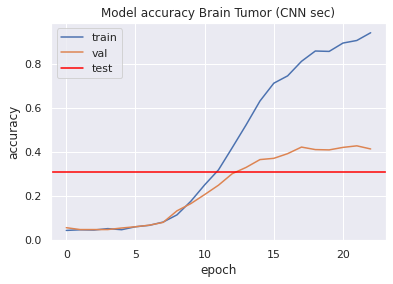

In [20]:
#CNN4
#CNN3
_batch_size = 64

model.compile( loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Entrenar modelo
history = model.fit(
    x = X_train1,
    y = y_train1,
    batch_size=_batch_size,
    epochs=30,
    verbose=1,
    callbacks = my_callbacks,
    validation_data=(X_val1, y_val1),
)
test = model.evaluate(X_test1,y_test1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axhline(test[1], color='red', label='test')
plt.title('Model accuracy Brain Tumor (CNN sec)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val','test'], loc='upper left')
plt.show()


<Figure size 1152x720 with 0 Axes>

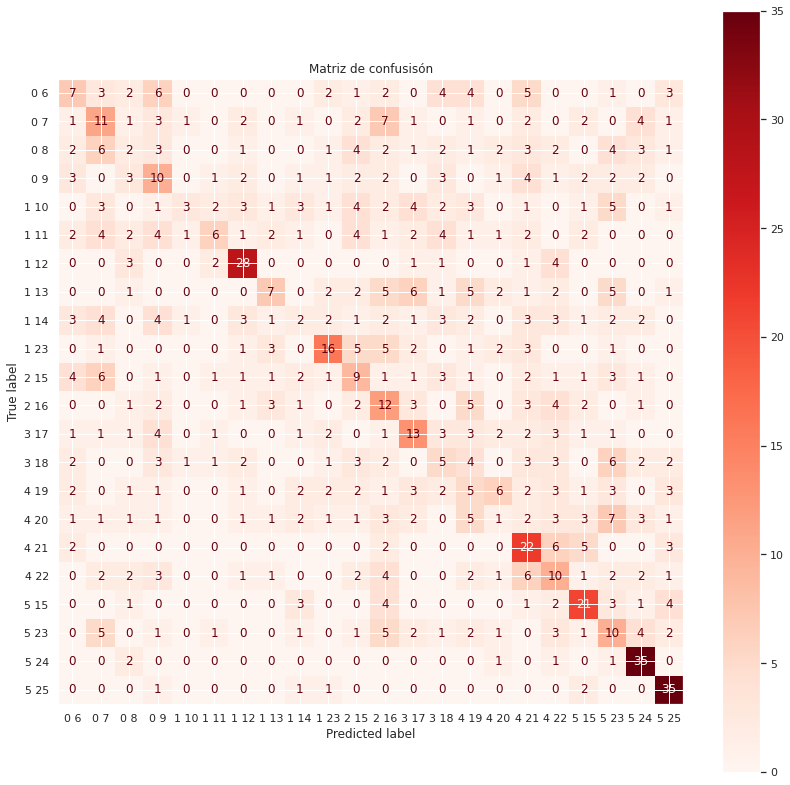

In [32]:
ypred = model.predict(X_test1)
y_test = np.array(y_test1)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig = plt.figure(figsize=(16, 10), facecolor='w', edgecolor='k')
classes = [y_train1.columns[i] for i in range(22)]
fig, ax = plt.subplots(figsize=(14,14))
cm = confusion_matrix(y_test.argmax(axis=1), ypred.argmax(axis=1),labels = range(22))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp = disp.plot(ax=ax, cmap=plt.cm.Reds)
ax.set_title('Matriz de confusisón')
plt.show()

### Entrenamiento red 2

Epoch 1/30
44/44 [==============================] - 23s 292ms/step - loss: 2.7569 - accuracy: 0.2692 - val_loss: 1.8097 - val_accuracy: 0.4815
Epoch 2/30
44/44 [==============================] - 13s 292ms/step - loss: 0.9649 - accuracy: 0.7461 - val_loss: 1.3893 - val_accuracy: 0.5952
Epoch 3/30
44/44 [==============================] - 13s 298ms/step - loss: 0.5563 - accuracy: 0.8800 - val_loss: 1.2647 - val_accuracy: 0.6449
Epoch 4/30
44/44 [==============================] - 16s 363ms/step - loss: 0.3821 - accuracy: 0.9315 - val_loss: 1.1376 - val_accuracy: 0.6690
Epoch 5/30
44/44 [==============================] - 16s 362ms/step - loss: 0.2735 - accuracy: 0.9595 - val_loss: 1.1750 - val_accuracy: 0.6634
Epoch 6/30
44/44 [==============================] - 13s 306ms/step - loss: 0.2134 - accuracy: 0.9723 - val_loss: 1.0850 - val_accuracy: 0.6804
Epoch 7/30
44/44 [==============================] - 14s 309ms/step - loss: 0.1550 - accuracy: 0.9847 - val_loss: 1.1058 - val_accuracy: 0.6776

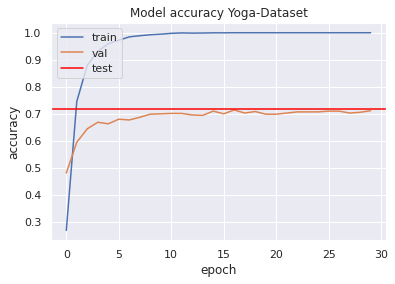

In [34]:

model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# hist = model.fit(train_set, validation_data=test_set, epochs=5)
_batch_size = 64
history = model2.fit(
    x = X_train1,
    y = y_train1,
    batch_size=_batch_size,
    epochs=30,
    verbose=1,
    callbacks = my_callbacks,
    validation_data=(X_val1, y_val1),
)



test = model2.evaluate(X_test1,y_test1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axhline(test[1], color='red', label='test')
plt.title('Model accuracy Yoga-Dataset')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val','test'], loc='upper left')
plt.show()


<Figure size 1152x720 with 0 Axes>

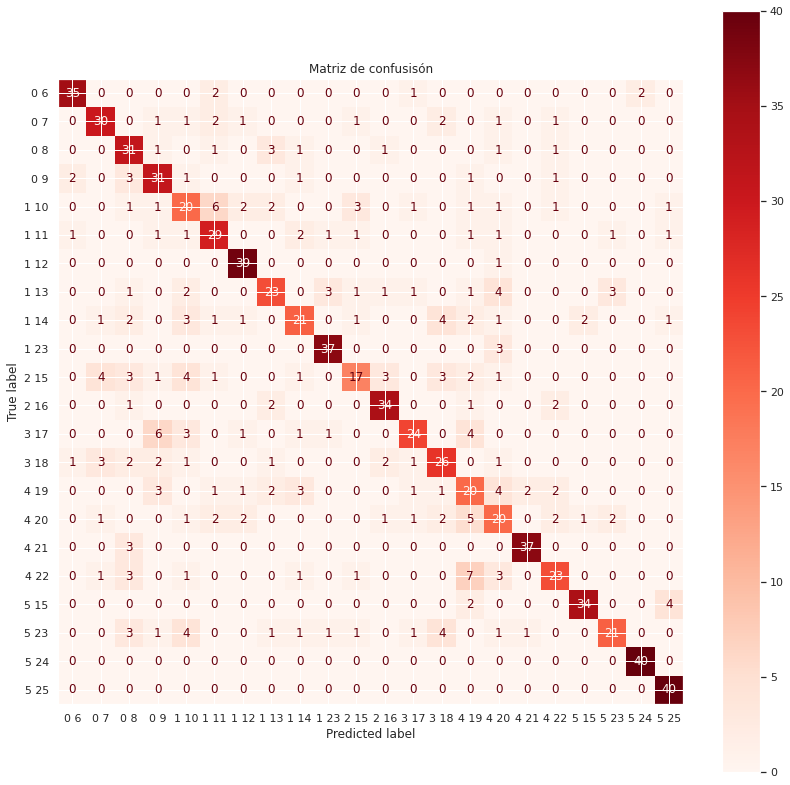

In [35]:
ypred = model2.predict(X_test1)
y_test = np.array(y_test1)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig = plt.figure(figsize=(16, 10), facecolor='w', edgecolor='k')
classes = [y_train1.columns[i] for i in range(22)]
fig, ax = plt.subplots(figsize=(14,14))
cm = confusion_matrix(y_test.argmax(axis=1), ypred.argmax(axis=1),labels = range(22))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp = disp.plot(ax=ax, cmap=plt.cm.Reds)
ax.set_title('Matriz de confusisón')
plt.show()

Exportamos el resultado del test.

In [ ]:
vamos_chile = model2.predict(X_test)
vamos_brasil=[]
for k in vamos_chile:
  vamos_brasil.append(list(Aux.keys())[np.argmax(k)])
len(vamos_brasil)
ax=data_test[[data_test.columns[0]]].astype(str)
#ax.drop([88,336],inplace=True)
ax['values'] = vamos_brasil
ax.to_csv('rusticos16.csv', index=False)  #nombre del archivo

# Análisis de resultados

Al ver los gráficos del accuracy logrado en el test, se observa una clara mejora de la red preentrenada respecto a la red creada. Se destaca la cantidad de parámetros entrenables de cada red:


*   **Modelo 1:** 554,134
*   **Modelo 2:** 551,958

Ambas redes cuentan con una cantidad similar de parámetros, pero la diferencia radica en que el modelo 1 distribuye sus parámetros entrenables entre las capas convolucionales y la densas, en cambio el modelo 2, solamente en la capa densa. 

Se concluye que al contar con tan pocos ejemplos y tener tantas clases a clasificar, una red preenetrenada puede ser de gran ayuda en la tarea, debido a la capacidad que tienen para reconocer contornos y distintas formas en las imágenes. Por otro lado, también es importante destacar las técnicas de data augmentation en caso que se cuenten con pocos ejemplos y en situaciones donde haya un gran desbalance en la data. De los valores de accuracy para ambos modelos, además del mapa de confusión, es evidente el mejor rendimiendo de la red preeentrenada respecto a la otra.

Por último, se destaca que otra alternativa de solución podría haber sido la clasificación por separado de la superclase y subclase. Al clasificar solo la combinación de estas dos como se realizó en el presente trabajo, se restringe mucho el espacio de clasificación posible para las imágenes.
